In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generating Datasets

In [3]:
decision_lambda = lambda x1, x2: 1 if (x1 + (3 * x2) - 2) > 0 else -1

def gen_data():
    """
    Generates random data points and classifies them.
    """
    data = np.random.randint(low=-40, high=40, size=(100,2))
    classification = np.array([[decision_lambda(d[0], d[1])] for d in data])

    return np.hstack((data, classification))

In [4]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float) the percentage of the data you want to be TRAINING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

In [5]:
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then -1's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==-1, :-1]

In [6]:
# Find a balanced dataset of positive and negative samples
def get_balanced_data():
    ratio = -1
    while ratio == -1 or abs(1 - ratio) > 0.1:
        data = gen_data()
        pos, neg = split_pos_neg(data)

        # Check ratio of positive and negative samples
        ratio = len(pos) / len(neg)
    
    return data

# Perceptron (2 Input Linear Unit)

In [7]:
# To be used later when measuring performance
weight_updates = 0

class linear_unit():
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs + 1)
        
    def output(self, data_point):
        """
        Returns the linear combination of the input and this unit's weights
        """
        # total = w0*1 + w1x1 + w2x2 + ...
        data_with_bias = np.hstack((np.array([1]), data_point[:-1]))
        t = data_with_bias * self.weights
        t = np.sum(t)
        
        return t
        
    def delta_rule(self, data, learning_rate, epochs):
        """
        Performs the delta rule training for a given number of epochs using gradient descent
        """
        global weight_updates
        
        # From NN_MitchelChapter4-1.pdf on canvas          
        for ep in range(epochs): 
            delta_w = np.zeros(self.weights.shape[0])
            for d in data:
                d_with_bias = np.hstack((np.array([1]), d[:-1]))
                o = 1 if self.output(d) > 0 else -1
                delta_w = delta_w + learning_rate * (d[2] - o) * d_with_bias     
            self.weights = self.weights + delta_w
            
            if np.sum(delta_w) != 0:
                weight_updates += 1
                
        return weight_updates
        
    def delta_rule_stochastic(self, data, learning_rate, epochs):
        """
        Performs the delta rule training for a given number of epochs using stochastic gradient descent
        """
        global weight_updates
        
        # From NN_MitchelChapter4-1.pdf on canvas          
        for ep in range(epochs): 
            for d in data:
                d_with_bias = np.hstack((np.array([1]), d[:-1]))
                o = 1 if self.output(d) > 0 else -1
                temp_weights = self.weights + learning_rate * (d[2] - o) * d_with_bias  
                
                if (temp_weights != self.weights).any():
                    weight_updates += 1
                    
                self.weights = temp_weights
                
        return weight_updates
            
        
    def error(self, data):
        """
        Returns the sum squared error of the data using this unit's weights
        """
        sum = 0
        for d in data:
            o = 1 if self.output(d) > 0 else -1
            sum = sum + (d[2] - o)**2
        return sum

# Plotting

In [54]:
def plot_error_over_epochs(epochs):   
    """
    Plot the training error for up to some number of epochs
    """ 
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    data = get_balanced_data()
    for i in range(epochs):
        unit.delta_rule(data, 0.1, 1)
        y.append(unit.error(data))
        
    plt.plot(x, y, '--r')
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.title('Error vs Training Epochs')
    plt.show()

def plot_decision_surface():
    """
    Plot the decision surface for 5, 10, 50, and 100 epochs
    """ 
    # Get data
    data = get_balanced_data()
    pos, neg = split_pos_neg(data)
    
    unit = linear_unit(2)
    
    # Set axis limits
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    
    for i in range(4):
        # Train linear unit
        if i == 0:
            unit.delta_rule(data, .0001, 5)
            l = '5 Epochs'
            c = 'thistle'
        elif i == 1:
            unit.delta_rule(data, .0001, 5)
            l = '10 Epochs'
            c = 'plum'
        elif i == 2:
            unit.delta_rule(data, .0001, 40)
            l = '50 Epochs'
            c = 'magenta'
        else:
            unit.delta_rule(data, .0001, 50)
            l = '100 Epochs'
            c = 'purple'
            
        # Plot decision boundary
        x = np.arange(-40, 40)
        yf = lambda x: ((unit.weights[1] / unit.weights[2]) * -x) - unit.weights[0]
        y = [yf(d) for d in x]
        plt.plot(x, y, color=c, label=l)
        #ax.fill_between(x, y, 40, color='lightcoral')
        #ax.fill_between(x, y, -40, color='lightblue')
            
    
    # Overlay training data
    plt.scatter(pos[:, 0], pos[:, 1], color='red')
    plt.scatter(neg[:, 0], neg[:, 1], color='blue')
    
    plt.title('Decision Boundary')
    plt.legend()
    plt.show()
    
def plot_error_training_rates():
    
    plt.xlim((0, 50))
    
    x = np.arange(51)
    data = get_balanced_data()
    
    for i in range(4):
    
        if i  == 0:
            lr = 0.1
            l = 'LR = 0.1'
            c = '--r'
        elif i == 1:
            lr = 0.01
            l = 'LR = 0.01'
            c = '--b'
        elif i == 2:
            lr = 0.001
            l = 'LR = 0.001'
            c = '--g'
        elif i == 3:
            lr = 0.0001
            l = 'LR = 0.0001'
            c = '--y'
    
        unit = linear_unit(2)
        y = []
        y.append(unit.error(data))
        for i in range(50):
            unit.delta_rule(data, lr, 1)
            y.append(unit.error(data))
        
        plt.plot(x, y, c, label=l)
    
    plt.title('Learning Rate Performance')
    plt.legend()
    plt.show()

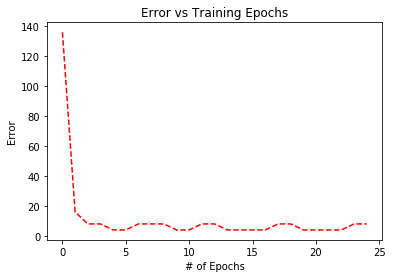

In [39]:
plot_error_over_epochs(25)

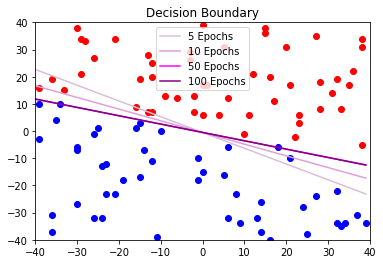

In [45]:
plot_decision_surface()

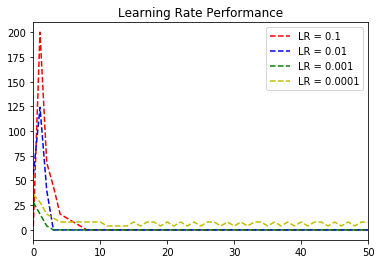

In [68]:
plot_error_training_rates()

## Learning Rate Performance Analysis

Based on the behaviour of the graph above, it appears that a Learning Rate of `0.1` and `0.01` does quickly converge to the optimal solution; however, after the initial training epoch there's a large "snap" in the error from it over correcting the initial weights. A Learning Rate of `0.0001` seems to perform poorly on the data because it gets stuck within a local minimum and can't work its way to the global minimum. The Learning Rate of `0.001` doesn't have the "snap" effect of the two larger learning rates, but still retains the ability to not be trapped in the local minimum. Therefore it appears that the `0.001` rate is superior on this data set.

In [70]:
import timeit

weight_updates = 0

data = get_balanced_data()

# Train perceptron using batch gradient descent
p = linear_unit(2)
time = timeit.timeit(lambda: p.delta_rule(data, 0.001, 50), number=1)

print('Epochs: 50')
print('Learning Rate: 0.001\n')

print('Batch Training:')
print(f'\tExecution Time: {time}')
print(f'\tNum of Weight Updates: {weight_updates}\n')

weight_updates = 0

# Train perceptron using stochastic gradient descent
p = linear_unit(2)
time = timeit.timeit(lambda: p.delta_rule_stochastic(data, 0.001, 50), number=1)

print('Stochastic Training:')
print(f'\tExecution Time: {time}')
print(f'\tNum of Weight Updates: {weight_updates}\n')

Epochs: 50
Learning Rate: 0.001

Batch Training:
	Execution Time: 0.1001774999999725
	Num of Weight Updates: 50

Stochastic Training:
	Execution Time: 0.09781699999996363
	Num of Weight Updates: 94



## Decaying Adaptive Rate

In [103]:
def learning_rate_decay(initial_learning_rate, epoch, decay_rate):
    return decay_rate**epoch * initial_learning_rate

def plot_error_decay(epochs):   
    """
    Plot the training error for up to some number of epochs of constant vs decay
    """ 
    data = get_balanced_data()
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    for i in range(epochs):
        unit.delta_rule(data, 0.1, 1)
        y.append(unit.error(data))        
    plt.plot(x, y, '--r')
    
    unit2 = linear_unit(2)
    
    x2 = np.arange(epochs)
    y2 = []
    for i in range(epochs):
        learning_rate = learning_rate_decay(0.1, i, 0.8)
        unit2.delta_rule(data, learning_rate, 1)
        y2.append(unit2.error(data))
    plt.plot(x2, y2, '--b')
    
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.legend(['Constant Rate', 'Decaying Rate'])
    plt.title('Error vs Training Epochs')
    plt.show()

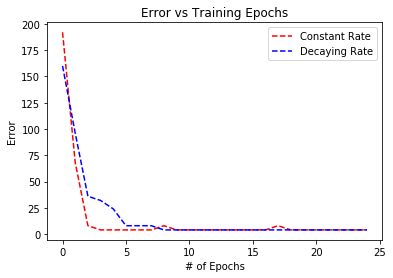

In [104]:
plot_error_decay(25)

## Decaying Rate Analysis
In the graph above the errors from a linear unit using a constant learning rate of `0.1` (depicted in red) and another unit utilizing a decaying rate starting at `0.1` (depicted in blue) are shown.

The constant rate unit comes to the same local minimum that the decaying rate does, but sooner. As training continues, the constant rate unit occasionally bounces out to a less optimal solution, but the decaying rate settles onto this solution. So in this case, depending on how long you trained the constant rate unit, you could obtain a slightly suboptimal solution if it was halted during one of its bounces. The decaying rate appears to not suffer from this drawback.

## Adaptive Learning Rate

In [91]:
def learning_rate_adaptive(learning_rate, error_diff, t, d, D):
    """
    error_diff: new error - previous error
    t: threshold
    d: multiplier if above threshold
    D: multiplier if less than threshold
    return new learning rate, keep new weights
    """     
    if error_diff >= t:
        return learning_rate * d, False
    else:
        return learning_rate * D, True

def plot_error_adaptive(epochs):   
    """
    Plot the training error for up to some number of epochs of constant vs adaptive
    """ 
    data = get_balanced_data()
    unit = linear_unit(2)
    
    x = np.arange(epochs)
    y = []
    for i in range(epochs):
        unit.delta_rule(data, 0.1, 1)
        y.append(unit.error(data))        
    plt.plot(x, y, '--r')
    
    unit2 = linear_unit(2)
    
    x2 = np.arange(epochs)
    y2 = []
    prev_error = unit2.error(data)
    learning_rate = 0.1
    for i in range(epochs):
        prev_weights = np.copy(unit2.weights)
        unit2.delta_rule(data, learning_rate, 1)        
        learning_rate, keep_weights = learning_rate_adaptive(learning_rate, unit2.error(data) - prev_error, 0.2, 0.9, 1.1)
        prev_error = unit2.error(data)
        if not keep_weights:
            unit2.weights = prev_weights
        y2.append(unit2.error(data))
    plt.plot(x2, y2, '--b')
    
    plt.xlabel('# of Epochs')
    plt.ylabel('Error')
    plt.legend(['Constant Rate', 'Adaptive Rate'])
    plt.title('Error vs Training Epochs')
    plt.show()

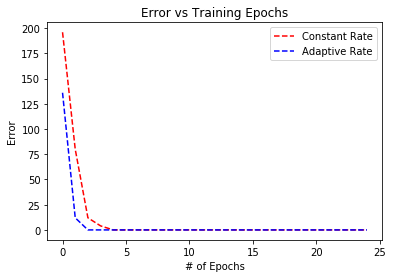

In [102]:
plot_error_adaptive(25)

## Adaptive Rate Analysis

In the graph above the errors from a linear unit using a constant learning rate of `0.1` (depicted in red) and another unit utilizing an adaptive rate starting at `0.1` (depicted in blue) are shown.

The parameters for the adaptive rate unit are as follows:
* Initial Learning Rate = `0.1`
* Error Threshold = `0.2`
* d value = `0.9`
* D value = `1.1`

In this situation both the constant and adaptive units quickly converge to an optimal solution. Yet the adaptive unit gets to this solution more quickly by virtue of its accelerating learning rate. It appears that the adaptive rate unit would be superior in situations where you have a limited number of training epochs to work with.